In [1]:

%run ../../load_magic/storage
s = Storage()

In [12]:

# Download CoinBase prices
from urllib.request import urlretrieve
import gzip
import os
import numpy as np
from datetime import datetime

In [20]:

# http://api.bitcoincharts.com/v1/csv/
def get_price_data(price_history_name, price_history_url, column_list):
    frame_name = str(price_history_name) + '_df'
    pickle_path = s.saves_folder + 'pickle/' + frame_name + '.pickle'
    if not os.path.isfile(pickle_path):
        
        csv_path = s.data_folder + 'csv/' + frame_name + '.csv'
        if not os.path.isfile(csv_path):

            out_file_path = s.data_folder + 'csv/' + str(price_history_name) + '.csv'
            if not os.path.isfile(out_file_path):
                print('Retrieving ' + price_history_url)
                local_filename, headers = urlretrieve(price_history_url)
                print('Decompressing ' + local_filename)
                with gzip.open(local_filename, 'rb') as f:
                    price_history_decompressed = f.read()
                print('Decoding to ' + out_file_path)
                with open(out_file_path, 'w') as output:
                    size = output.write(price_history_decompressed.decode())
            
            print('Converting ' + out_file_path)
            price_history_df = pd.read_csv(out_file_path, encoding=s.encoding_type, header=None)

            price_history_df.columns = column_list
            if 'time_stamp' in column_list:
                price_history_df['date'] = price_history_df['time_stamp'].map(lambda x: pd.to_datetime(x, unit='s'))
            else:
                price_history_df['date'] = price_history_df['date'].map(lambda x: datetime.strptime(str(x).strip(), '%x'))
            price_history_df = price_history_df.sort_values('date')
            price_history_df['year'] = price_history_df['date'].map(lambda x: x.year)
            price_history_df['month'] = price_history_df['date'].map(lambda x: x.month)
            price_history_df['day'] = price_history_df['date'].map(lambda x: x.day)
            price_history_df['week_day'] = price_history_df['date'].map(lambda x: x.weekday())
            hard_date = price_history_df ['date'].min()
            price_history_df['days_from'] = price_history_df ['date'].map(lambda x: (x - hard_date).days)
            price_history_df['log_price'] = price_history_df['price'].map(lambda x: np.log(x))
            price_history_df['price_diff'] = price_history_df['price'].diff()
            price_history_df['log_diff'] = price_history_df['log_price'].diff()

            match_series = (price_history_df['log_price'] <= 0)
            price_history_df = price_history_df[~match_series]
            
            print('Now saving as a csv.')
            price_history_df.to_csv(csv_path, sep=',', encoding=s.encoding_type, index=False)
                
        else:
            print('Loading ' + frame_name + ' from csv')
            price_history_df = load_csv(frame_name, folder_path=saves_folder)
            price_history_df['date'] = price_history_df['date'].map(lambda x: pd.to_datetime(x))

    else:
        print('Loading ' + frame_name + ' from pickle')
        price_history_df = load_object(frame_name)
    
    return price_history_df

In [ ]:

# Validates with https://en.wikipedia.org/wiki/History_of_bitcoin
price_history_url = 'http://api.bitcoincharts.com/v1/csv/coinbaseUSD.csv.gz'
column_list = ['time_stamp', 'price', 'idono']
coinbaseUSD_df = get_price_data('coinbaseUSD', price_history_url, column_list)
coinbaseUSD_df.head()

Converting ../data/csv/coinbaseUSD.csv


In [ ]:

hard_date = coinbaseUSD_df ['date'].min()
coinbaseUSD_df['days_from'] = coinbaseUSD_df ['date'].map(lambda x: (x - hard_date).days)
coinbaseUSD_df['price_diff'] = coinbaseUSD_df.sort_values('date')['price'].diff()
coinbaseUSD_df['log_price'] = coinbaseUSD_df['price'].map(lambda x: np.log(x))
coinbaseUSD_df['log_diff'] = coinbaseUSD_df.sort_values('date')['log_price'].diff()
coinbaseUSD_df.head()

In [6]:

pickle_path = saves_folder + 'pickle/coinbaseUSD_df.pickle'
try:
    attempt_to_pickle(coinbaseUSD_df, pickle_path, raise_exception=True)
except:
    print('Now saving as a csv.')
    csv_path = data_folder + 'csv/coinbaseUSD_df.csv'
    coinbaseUSD_df.to_csv(csv_path, sep=',', encoding=encoding, index=False)
coinbaseUSD_df.head()

Pickling to ../saves/pickle/coinbaseUSD_df.pickle
[Errno 22] Invalid argument : Couldn't save 315,429,708 cells as a pickle.
Now saving as a csv.


,time_stamp,price,idono,date,year,month,day,week_day,log_price,log_diff,days_from,price_diff
0,1417412036,300.0,0.010000,2014-12-01 05:33:56,2014,12,1,0,5.703782,NaN,0,NaN
1,1417412423,300.0,0.010000,2014-12-01 05:40:23,2014,12,1,0,5.703782,0.000000,0,0.0
2,1417415048,370.0,0.010000,2014-12-01 06:24:08,2014,12,1,0,5.913503,0.209721,0,70.0
3,1417416612,370.0,0.026556,2014-12-01 06:50:12,2014,12,1,0,5.913503,0.000000,0,0.0
4,1417498166,377.0,0.010000,2014-12-02 05:29:26,2014,12,2,1,5.932245,0.018742,0,7.0


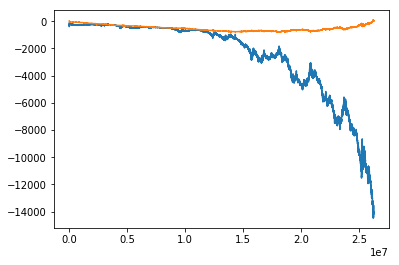

In [7]:

%matplotlib inline
from matplotlib import pyplot as plt
from pyhsmm.util.plot import pca_project_data

column_list = ['days_from', 'price']
line_2d = plt.plot(pca_project_data(coinbaseUSD_df[column_list].as_matrix(), 2))

In [8]:

def get_min_max(df, column_name, circle_min=5, circle_max=500):
    min_max_scaler = MinMaxScaler(feature_range=(circle_min, circle_max))
    min_max = min_max_scaler.fit_transform(df[column_name].values.reshape(-1, 1))
    
    return min_max

In [9]:

%matplotlib inline
import random
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

numeric_list = ['price', 'year', 'month', 'day', 'week_day', 'log_price', 'price_diff', 'log_diff']
column_list = random.sample(numeric_list, 4)
df = coinbaseUSD_df[column_list].dropna()
df.sample(5).T

,7371701,19520476,15156102,22231761,9469035
week_day,6.00,5.00,3.00,4.00,1.00
price_diff,0.01,-0.31,-0.03,0.00,0.04
price,413.47,4140.88,1864.40,5707.75,688.00
month,3.00,8.00,5.00,10.00,6.00


In [ ]:

c_column_name = column_list.pop()
s_column_name = column_list.pop()
df_matrix = df[column_list].as_matrix()
y_column_name = column_list.pop()
x_column_name = column_list.pop()
cmap = plt.get_cmap('viridis_r')

In [ ]:

from sklearn.cluster import DBSCAN

# Compute DBSCAN
db_DBSCAN = DBSCAN().fit(df_matrix)

In [ ]:

# Don't want to fit this puppy again
store_objects(db_DBSCAN=db_DBSCAN)

In [ ]:

fig = plt.figure(figsize=(13, 13))
ax = fig.add_subplot(111, autoscale_on=True)
path_collection = ax.scatter(df_matrix[:, 0], df_matrix[:, 1],
                             s=get_min_max(df, s_column_name),
                             c=get_min_max(df, c_column_name),
                             edgecolors=(0, 0, 0), cmap=cmap)
title_text = ('Scatterplot of the Coinbase ' +
              x_column_name + ' and ' +
              y_column_name + ' Fields with ' +
              s_column_name + ' as the Size and ' +
              c_column_name + ' as the Color')
text = plt.title(title_text)

In [ ]:

coinbaseUSD_df.loc[coinbaseUSD_df.shape[0]-1]


## Buying Digital Currency

Fees are added to the amount entered to arrive at the total for the order. For example, if you enter \$100 USD as the amount of BTC to buy, and the fee is 1.49%, your total will be \$101.49. That total will be charged to your payment method and you will receive \$100 worth of BTC.

In [ ]:

coinbaseUSD_df['date'].dtype

In [ ]:

groupby_list = ['year', 'month', 'day']
monday_price_df = coinbaseUSD_df.groupby(groupby_list,
                                         as_index=False).apply(lambda x: x.loc[[x.date.idxmax()]]).copy()
match_series = (monday_price_df['week_day'] == 0)
monday_price_df = monday_price_df[match_series].reset_index(drop=True)

In [ ]:

from datetime import datetime
import pandas as pd

trading_fee = 0.0149
weekly_budget = 5.0
latest_price = coinbaseUSD_df.loc[coinbaseUSD_df.shape[0]-1]['price']
def total_saved(weekly_budget, format_result=True):
    weekly_amount = weekly_budget - weekly_budget*trading_fee
    column_list = ['date_time', 'shares_added']
    rows_list = []
    trading_date = datetime(monday_price_df.loc[0, 'year'].squeeze(),
                            monday_price_df.loc[0, 'month'].squeeze(),
                            monday_price_df.loc[0, 'day'].squeeze())
    for row_index, row_series in monday_price_df.iterrows():
        row_dict = {}
        row_dict['date_time'] = row_series['date']
        row_dict['shares_added'] = weekly_amount/row_series['price']
        rows_list.append(row_dict)

    weekly_amount_df = pd.DataFrame(rows_list, columns=column_list)
    total_amount = weekly_amount_df['shares_added'].sum()*latest_price
    if format_result:
        total_amount = '${:,.2f}'.format(total_amount)
    
    return total_amount

In [ ]:

print(total_saved(10.))

In [ ]:

import statsmodels.formula.api as smf

# Use ols function for calculating the F-statistic and associated p value
price_history_ols = smf.ols(formula='log_price ~ time_stamp', data=coinbaseUSD_df)
price_history_fitted = price_history_ols.fit()
price_history_fitted.summary()

In [ ]:

params_series = price_history_fitted.params

def date_when(amount):
    time_stamp = (np.log(amount)-params_series.loc['Intercept'])/params_series.loc['time_stamp']
    date_time = pd.to_datetime(time_stamp, unit='s')
    
    return date_time.strftime('%Y-%m-%d')

In [ ]:

date_when(110000)

In [ ]:

%matplotlib inline

axes_sub_plot = coinbaseUSD_df.plot(x='date', y='price', kind='line', figsize=(15, 5), logy=True)

In [ ]:

# How do you add a second line to the plot?
axes_sub_plot.plot(x=coinbaseUSD_df['date'], y=np.exp(params_series.loc['Intercept']+coinbaseUSD_df['log_price']*params_series.loc['time_stamp']),
                   kind='line', figsize=(15, 5), logy=True)

In [ ]:

coinbaseUSD_df.loc[0, 'date']

In [ ]:

column_list = ['amount_per_week', 'total_saved']
amount_per_week = range(0, 500)
amount_saved = [total_saved(amount, format_result=False) for amount in amount_per_week]
rows_list = [dict(zip(column_list, [w, s])) for w, s in zip(amount_per_week, amount_saved)]
weekly_amount_df = pd.DataFrame(rows_list, columns=column_list)
axes_sub_plot = weekly_amount_df.plot(x='amount_per_week', y='total_saved', kind='line', figsize=(15, 5), logy=False)

In [ ]:

price_history_url = None
column_list = ['date', 'close', 'volume', 'price', 'high', 'low']
WMT_df = get_price_data('WMT', price_history_url, column_list)
WMT_df.head()

In [ ]:

coinbaseUSD_df['log_diff'].std()

In [ ]:

match_series = (WMT_df['date'] < coinbaseUSD_df.loc[0, 'date'])
WMT_df[~match_series]['log_diff'].std()

In [ ]:

coinbaseUSD_df.shape

In [3]:

SaP_df = pd.read_html(data_folder + 'html/S_and_P_500_by_month.html')[0]

ImportError: lxml not found, please install it

In [ ]:

SaP_df.columns = ['date', 'price']
SaP_df = SaP_df.reindex(SaP_df.index.drop(0))
SaP_df['date'] = SaP_df['date'].map(lambda x: pd.to_datetime(x.strip()))
match_series = (SaP_df['date'] < coinbaseUSD_df.loc[0, 'date'])
SaP_df = SaP_df[~match_series]
SaP_df['price'] = SaP_df['price'].map(lambda x: float(x))
SaP_df['year'] = SaP_df['date'].map(lambda x: x.year)
SaP_df['month'] = SaP_df['date'].map(lambda x: x.month)
SaP_df['day'] = SaP_df['date'].map(lambda x: x.day)
SaP_df['week_day'] = SaP_df['date'].map(lambda x: x.weekday())
SaP_df['log_price'] = SaP_df['price'].map(lambda x: np.log(x))
SaP_df['log_diff'] = SaP_df.sort_values('date')['price'].diff()
SaP_df.sort_values('log_diff', ascending=False).head()

In [ ]:

# Why is the S&P 500 volatility so much greater than Coinbase?
match_series = (SaP_df['date'] < coinbaseUSD_df.loc[0, 'date'])
SaP_df[~match_series]['log_diff'].std()

In [ ]:

# From https://www.investopedia.com/ask/answers/021015/what-best-measure-given-stocks-volatility.asp


When selecting a security for investment, traders look at its historical volatility to help determine the relative risk of a potential trade. There are numerous metrics that measure volatility in differing contexts, and each trader has favorites. Regardless of which metric you utilize, a firm understanding of the concept of volatility and how it is measured is essential to successful investing. Simply put, volatility is a reflection of the degree to which price moves. A stock with a price that fluctuates wildly, hits new highs and lows or moves erratically is considered highly volatile. A stock that maintains a relatively stable price has low volatility. A highly volatile stock is inherently riskier, but that risk cuts both ways. When investing in a volatile security, the risk of success is increased just as much as the risk of failure. For this reason, many traders with a high risk tolerance look to multiple measures of volatility to help inform their trade strategies.

The primary measure of volatility used by traders and analysts is standard deviation. This metric reflects the average amount a stock's price has differed from the mean over a period of time. It is calculated by determining the mean price for the established period and then subtracting this figure from each price point. The differences are then squared, summed and averaged to produce the variance. Because the variance is the product of squares, it is no longer in the original unit of measure. Since price is measured in dollars, a metric that uses dollars squared is not very easy to interpret. Therefore, standard deviation is calculated by taking the square root of the variance, which brings it back to the same unit of measure as the underlying data set.

Chartists use a technical indicator called Bollinger Bands to analyze standard deviation over time. Bollinger Bands are comprised of three lines: the simple moving average (SMA) and two bands placed one standard deviation above and below the SMA. The SMA is a moving average that changes with each session to incorporate that day's changes, and the outer bands mirror that change to reflect the corresponding adjustment to the standard deviation. Standard deviation is reflected by the width of the Bollinger Bands. The wider the Bollinger Bands, the more volatile a stock's price within the given period. A stock with low volatility has very narrow Bollinger Bands that sit close to the SMA.

For a more comprehensive assessment of risk, measure multiple forms of volatility. Where standard deviation measures a security's price movements compared to its average over time, beta measures a security's volatility relative to that of the wider market. A beta of 1 means the security has volatility that mirrors the degree and direction of the market as a whole. This means that if the S&P 500 takes a sharp dip, the stock in question is likely to follow suit. Relatively stable securities, such as utilities, have beta values of less than 1, reflecting their lower volatility. Stocks in rapidly changing fields, especially in the technology sector, have beta values of more than 1. A beta of 0 indicates the underlying security has no volatility. Cash is an excellent example, if no inflation is assumed.